# Setup

In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns
import pickle
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from mne.stats import fdr_correction
from scipy.stats import mannwhitneyu, pearsonr, spearmanr, kruskal
acs_color, healthy_color = sns.color_palette('colorblind')[3], sns.color_palette('colorblind')[0]


curr_dir = mkdirifnotexists(os.path.join('serum_metabolomics_signatures'))
metabolon_dir = mkdirifnotexists(os.path.join(curr_dir, 'metabolon'))
nigtingale_dir = mkdirifnotexists(os.path.join(curr_dir, 'nigtingale'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


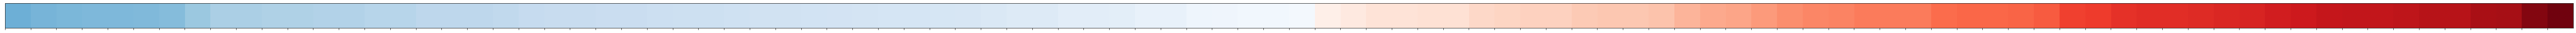

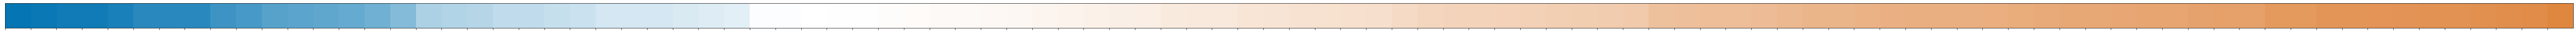

In [3]:
sns.palplot(_get_scale_colors([cm_healthy, cm_acs], np.sort(np.random.uniform(-10, 30, 100)), boundries=[-10, 40] ))

# Load data

In [4]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')

acs_data['ACS sample'], pnp_data['ACS sample'] = 1, 0

pnp_data.index = pnp_data.index.astype(str)
acs_data.index = acs_data.index.astype(str)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## metabolon

In [7]:
updated_metabs1 = pd.read_csv('additional_metabolon_files/updated_metabs1.csv', index_col=0)
updated_metabs1['SUPER_PATHWAY'] = updated_metabs1['SUPER_PATHWAY'].fillna('Unknowns')
updated_metabs1['SUB_PATHWAY'] = updated_metabs1['SUB_PATHWAY'].fillna('Unknowns')

metabolon_metabolite_name_dic = updated_metabs1['BIOCHEMICAL'].to_dict()
metabolon_metabolite_super_pathway_dic = updated_metabs1['SUPER_PATHWAY'].to_dict()
metabolon_metabolite_sub_pathway_dic = updated_metabs1['SUB_PATHWAY'].to_dict()

In [8]:
updated_metabs1.loc[metabolon.df.columns].to_csv(os.path.join(curr_dir, '961_metabolon_metabolites.csv'))

In [11]:
storage_bad_metabs = pd.read_pickle(os.path.join('data', 'storage_time_bad_metabs_bonf.pkl'))

In [12]:
pnp_data_metabolon = pd.read_csv(os.path.join('data', 'pnp_data_metabolon_storage_residuals.csv'))
pnp_data_metabolon['RegistrationCode'] = pnp_data_metabolon['RegistrationCode'].astype(str)
pnp_data_metabolon.set_index(['RegistrationCode'], inplace=True)
acs_data_metabolon = pd.read_csv(os.path.join('data', 'acs_data_metabolon_storage_residuals.csv')).dropna(subset=['100000007'])
acs_data_metabolon['RegistrationCode'] = acs_data_metabolon['RegistrationCode'].astype(str)
acs_data_metabolon.set_index(['RegistrationCode'], inplace=True)

data = pd.concat((pnp_data_metabolon, acs_data_metabolon), axis=0, sort=False)
print (data.shape)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (43,3236) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1,11,24,31,41,97,108,111,112,113,132,133,134,135,136,137,138,139,140,141,142,143,144,146,149,150,151,152,153,154,156,158,160,170,171,180,185,3213) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(629, 4682)


## metabolon r2 values

In [13]:
r2_df = # Supplementary Table 6 from https://doi.org/10.1038/s41586-020-2896-2

r2_df = r2_df.clip(lower=0, upper=0.3)

# Diabetes enrichment

## logit

In [14]:
acs_data_metabolon.loc[:, 'DM'] = (acs_data_metabolon.loc[:, 'Glucose Disorder: DM1']==1) | \
                                                                (acs_data_metabolon.loc[:, 'Glucose Disorder: DM2']==1) | \
                                                                (acs_data_metabolon.loc[:, 'HbA1C']>6.4)

dm_acs = acs_data_metabolon.dropna(subset=['100000010'])[acs_data_metabolon['DM']==1].index.astype(str)
nondm_acs = acs_data_metabolon.dropna(subset=['100000010'])[acs_data_metabolon['DM']==0].index.astype(str)

In [15]:
y = 'DM'
acs_data_metabolon['const'] = 1
covariates = ['Age', 'gender', 'const', 'bmi']
use_covariates = True
cols = metabolon.df.columns
samples = dm_acs.tolist() + nondm_acs.tolist()

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm(cols):
    if covariates:
        try:
            log = Logit(acs_data_metabolon.loc[samples, y].astype(float), 
                                    acs_data_metabolon.loc[samples, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results_dm = logit_results.dropna()
logit_results_dm['directional pval'] = logit_results_dm.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)

 33%|███▎      | 318/961 [00:02<00:05, 117.67it/s]/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 63%|██████▎   | 610/961 [00:05<00:02, 118.97it/s]/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
100%|██████████| 961/961 [00:08<00:00, 113.55it/s]


# MMC no HPN + Dyslipidemia

In [16]:
mmc = pd.read_csv(os.path.join('Matching/PNP1-ACS_matching/', 'PNP1-ACS_metabolon_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
mmc_pnp = mmc[mmc['ACS sample']==0].index.astype(str)
mmc_acs = mmc[mmc['ACS sample']==1].index.astype(str)

In [18]:
y = 'ACS sample'
data['const'] = 1
covariates = ['Age', 'gender', 'const']
use_covariates = True
cols = metabolon.df.columns
samples = mmc_pnp.tolist() + mmc_acs.tolist()

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm(cols):
    if covariates:
        try:
            log = Logit(data.loc[samples, y].astype(float), 
                                    data.loc[samples, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results_mmc_no_hpn = logit_results.dropna()
logit_results_mmc_no_hpn['directional pval'] = logit_results_mmc_no_hpn.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)

 29%|██▉       | 277/961 [00:02<00:05, 120.59it/s]/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 33%|███▎      | 314/961 [00:02<00:05, 113.26it/s]/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 34%|███▍      | 326/961 [00:03<00:05, 106.29it/s]/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 64%|██████▎   | 611/961 [00:05<00:02, 120.55it/s]/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
100%|██████████|

In [23]:
circ_heatmap_df_sorted = pd.concat((logit_results_mmc_no_hpn['directional pval'].rename('Healthy-ACS'), 
                                                            logit_results_dm['directional pval'].rename('DM-ACS'), 
                                                            r2_df), axis=1).dropna().sort_values('Healthy-ACS')
circ_heatmap_df_sorted['SUPER_PATHWAY'] = circ_heatmap_df_sorted.rename(index=metabolon_metabolite_super_pathway_dic).index
circ_heatmap_df_sorted = circ_heatmap_df_sorted.sort_values(['SUPER_PATHWAY', 'Healthy-ACS']).drop('SUPER_PATHWAY', axis=1)
circ_heatmap_df_sorted.to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'))
circ_heatmap_df_sorted

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
100020427,-10.342897,2.562632,0.009726,0.000000,0.119565,0.000000
100004523,-9.492389,-0.013057,0.036805,0.200714,0.005265,0.141974
1141,-9.405454,1.624212,0.009235,0.010484,0.018700,0.000000
100001293,-8.461528,-0.282871,0.000000,0.000000,0.066709,0.000000
100004056,-8.291514,0.502567,0.049153,0.120917,0.000000,0.000000
...,...,...,...,...,...,...
100015967,8.993728,-0.378462,0.123034,0.165167,0.090812,0.000000
100001296,9.249873,-1.024894,0.023017,0.244758,0.001990,0.000000
501,9.791267,-0.512215,0.000000,0.012121,0.001731,0.000000
1869,10.607016,-1.050605,0.005118,0.017169,0.027414,0.000000


In [24]:
saved_metab_enrich = logit_results_mmc_no_hpn.copy()
saved_metab_enrich['BIOCHEMICAL'] = logit_results_mmc_no_hpn.rename(index=metabolon_metabolite_name_dic).index.values
saved_metab_enrich = saved_metab_enrich.sort_values('Logit pval').drop('Logit log', axis=1)
saved_metab_enrich['Enriched in ACS'] = saved_metab_enrich['directional pval'] > 0
saved_metab_enrich['Logit qval'] = fdr_correction(saved_metab_enrich['Logit pval'])[1]
saved_metab_enrich.to_csv(os.path.join(metabolon_dir, 'metabolon_enrichments_MMC_no_HPN+DYS.csv'))

# Plot - merge with microbiome

## main figure

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


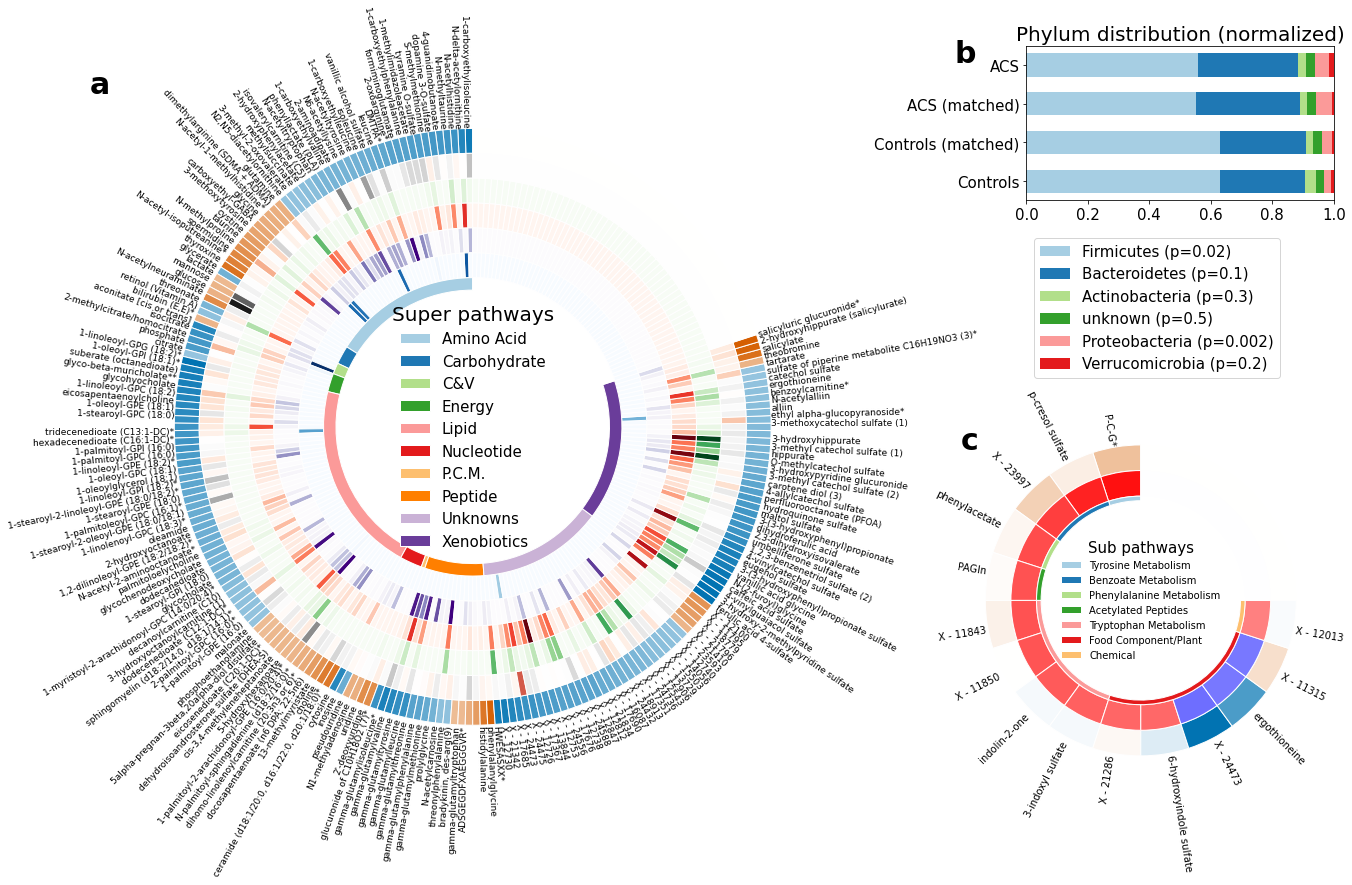

In [61]:
circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]

# FDR 10%
df = circ_heatmap_df_sorted.loc[(fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)))[1] < 0.1)]

df.to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_MMC_no_HPN_DYS-DM.csv'))

df = df[df.index.isin(circ_heatmap_df_sorted.abs().sort_values('Healthy-ACS').tail(200).index)]

df = pd.concat((df, pd.DataFrame(0, index=['']*int(df.shape[0]*0.25), columns=df.columns)), axis=0, sort=False)

super_pathway_names = df.rename(index=metabolon_metabolite_super_pathway_dic).index.unique().values.tolist()
group_size=[df.rename(index=metabolon_metabolite_super_pathway_dic).index.value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'DM-ACS':[plt.cm.RdGy],
                 'Microbiome r2':[plt.cm.Greens], 'Diet r2':[plt.cm.Reds], 'Genetics r2':[plt.cm.Blues], 'Traditional Risk Factors r2':[plt.cm.Purples]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-11, 11)
boundries['DM-ACS'] = (-7, 7)
 
    
fig = plt.figure(figsize=(21, 14))
gs = gridspec.GridSpec(9, 15, wspace=.1, hspace=0.3)

circ_ax = fig.add_subplot(gs[:, :8])
taxa_ax = fig.add_subplot(gs[:2, 11:])
sgb_ax = fig.add_subplot(gs[5:8, 11:14])

label_fontsize=20
tick_fontsize=15


ax = circ_ax
radius = 1.2
radius_step = 0.1

for layer in df.columns:
    if layer == 'Healthy-ACS':
        labels = df.rename(index=metabolon_metabolite_name_dic).rename(index={'2,3-dihydroxy-5-methylthio-4-pentenoate (DMTPA)*': 'DMTPA*'}).index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1., textprops={'fontsize': 9},
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)
    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, [s.replace('Cofactors and Vitamins','C&V').replace('Partially Characterized Molecules', 'P.C.M.') for s in super_pathway_names][:-1], #super_pathway_names,
                                  title="Super pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=tick_fontsize, frameon=False)
legend.get_title().set_fontsize(str(label_fontsize))


ax = taxa_ax
with open(os.path.join('TaxaComposition', 'required_data_for_plot.pkl'), 'rb') as handle:
    required_data_for_plot = pickle.load(handle)
df_mean = required_data_for_plot['df_mean']
df_std = required_data_for_plot['df_std']

labels = ['Controls', 'Controls (matched)', 'ACS (matched)', 'ACS']
width=0.6

matched_acs_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'matched_acs_mb_full_phyla.csv'), index_col=0)
matched_pnp_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'matched_pnp_mb_full_phyla.csv'), index_col=0)
acs_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'acs_mb_full_phyla.csv'), index_col=0)
pnp_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'pnp_mb_full_phyla.csv'), index_col=0)

paired_colors = sns.color_palette('Paired', df_mean.shape[0])
for i, color in zip(range(df_mean.shape[0]), paired_colors):
    label = df_mean.index[i]
    t, p  = kruskal(matched_pnp_mb_full_phyla.loc[:, label].dropna(), matched_acs_mb_full_phyla.loc[:, label].dropna())
#     print (label + ' (p=%0.1g)'%(p))
    if i == 0:
        ax.barh(labels, df_mean.loc[label], width, label=label + ' (p=%0.1g)'%(p), color=color) #  yerr=df_std.loc[label]
    else:
        ax.barh(labels, df_mean.loc[label], width, label=label+ ' (p=%0.1g)'%(p), left=df_mean.head(i).sum(), color=color)
ax.tick_params(labelsize=tick_fontsize)
ax.set_title('Phylum distribution (normalized)', fontsize=label_fontsize)
ax.set_yticklabels(labels)
ax.set_xlim((0, 1))

leg = ax.legend(ncol=1, loc='upper left' , bbox_to_anchor=(0, -0.2),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='')
leg.get_title().set_fontsize(str(label_fontsize))


ax = sgb_ax
with open(os.path.join('specific_mb-metabolite_pathway', 'required_data_for_plot.pkl'), 'rb') as handle:
    required_data_for_plot = pickle.load(handle)

df = required_data_for_plot['df'].replace({'p-cresol-glucuronide*': 'P-C-G*', 'phenylacetylglutamine': 'PAGln'})
super_pathway_names = df['SUB_PATHWAY'].unique().tolist()
group_size=[df['SUB_PATHWAY'].value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'Correlation with bacteria':[plt.cm.bwr_r]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-7, 7)
boundries['Correlation with bacteria'] = (-0.35, 0.35)

# ax.axis('equal')

radius = 1.7
radius_step = 0.28

for layer in df.columns:
    if layer == 'BIOCHEMICAL' or layer == 'SUB_PATHWAY':
        continue
    if layer == 'Healthy-ACS':
        labels = df['BIOCHEMICAL']
#         labels = df.index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1.,
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)

    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
#                   colors=sns.color_palette('Paired', len(super_pathway_names)), 
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, super_pathway_names[:-1],
                                  title="Sub pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=10, frameon=False)
legend.get_title().set_fontsize('15')


fig.tight_layout()
plt.text(-0.1, 1.05, 'a', ha='center', va='center', transform=circ_ax.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.2, 0.95, 'b', ha='center', va='center', transform=taxa_ax.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.25, 1.2, 'c', ha='center', va='center', transform=sgb_ax.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Figure1.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Figure1.pdf'), dpi=300, bbox_inches='tight')

## metabolomics supplementary

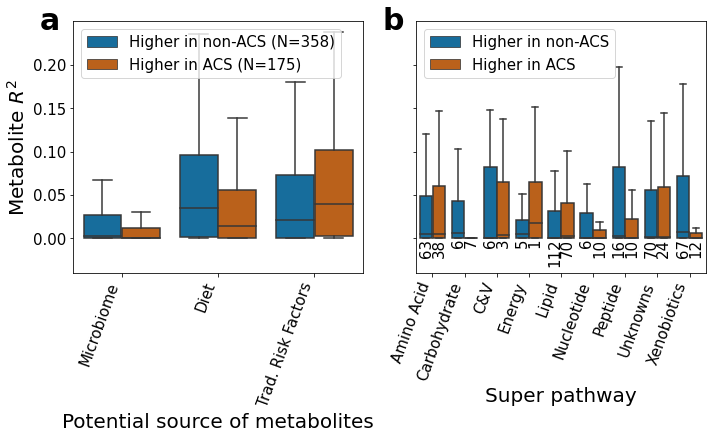

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

label_fontsize=20
tick_fontsize=15

circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]
# bonferonni 0.05
# df = circ_heatmap_df_sorted.loc[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]]
# FDR 10%
df = circ_heatmap_df_sorted.loc[(fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)))[1] < 0.1)]

df = pd.concat((df, pd.DataFrame(0, index=['']*int(df.shape[0]*0.25), columns=df.columns)), axis=0, sort=False)

# df.drop('').to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_MMC_no_HPN_DYS-DM.csv'))

super_pathway_names = df.rename(index=metabolon_metabolite_super_pathway_dic).index.unique().values.tolist()
group_size=[df.rename(index=metabolon_metabolite_super_pathway_dic).index.value_counts().loc[i] for i in super_pathway_names]

ax = axes[0]
melted_df = df.drop('').drop(['DM-ACS', 'Genetics r2'], axis=1).rename(columns={k:k.replace(' r2', '') for k in df.columns})\
                    .rename(columns={'Traditional Risk Factors': 'Trad. Risk Factors'}).melt(id_vars=['Healthy-ACS'])
melted_df['Healthy-ACS'] = melted_df['Healthy-ACS']>0
melted_df['Healthy-ACS'].replace({True:'Higher in ACS (N=%0.1d)'%((df['Healthy-ACS']>0).sum()), False:'Higher in non-ACS (N=%0.1d)'%((df['Healthy-ACS']<0).sum())}, inplace=True)
sns.boxplot(data=melted_df, x='variable', y='value', hue='Healthy-ACS', ax=ax, palette=[healthy_color, acs_color], showfliers=False)
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_ylabel('Metabolite $R^2$', fontsize=label_fontsize)
ax.set_xlabel('Potential source of metabolites', fontsize=label_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.legend(title=None, fontsize=tick_fontsize, loc='upper left')

ax = axes[1]
melted_df = df.drop('').drop('DM-ACS', axis=1).rename(index=metabolon_metabolite_super_pathway_dic).rename_axis('SUPER_PATHWAY').reset_index().melt(id_vars=['Healthy-ACS', 'SUPER_PATHWAY'])
melted_df['Healthy-ACS'] = melted_df['Healthy-ACS']>0
melted_df['Healthy-ACS'].replace({True:'Higher in ACS', False:'Higher in non-ACS'}, inplace=True)
melted_df['SUPER_PATHWAY'].replace({'Cofactors and Vitamins':'C&V', 'Partially Characterized Molecules':'P.C.M.'}, inplace=True)
sns.boxplot(data=melted_df[melted_df['SUPER_PATHWAY']!='P.C.M.'], x='SUPER_PATHWAY', y='value', hue='Healthy-ACS', ax=ax, palette=[healthy_color, acs_color], showfliers=False)
ax.set_ylim((-0.04, ax.get_ylim()[1]))
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Metabolite $R^2$', fontsize=label_fontsize)
ax.set_ylabel('', fontsize=label_fontsize)
ax.set_xlabel('Super pathway', fontsize=label_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.legend(title=None, fontsize=tick_fontsize, loc='upper left')

metab_counts = melted_df[melted_df['variable']=='Diet r2'].groupby(['SUPER_PATHWAY', 'Healthy-ACS']).apply(lambda x: x.shape[0])

for xtick, i in zip([s.get_text() for s in ax.get_xticklabels()], ax.get_xticks()):
    try:
        ax.text(i-0.2, 0, metab_counts.loc[(xtick, 'Higher in non-ACS')], rotation=90, ha='center', va='top', fontsize=tick_fontsize)
    except:
        pass
    try:
        ax.text(i+0.2, 0, metab_counts.loc[(xtick, 'Higher in ACS')], rotation=90, ha='center', va='top', fontsize=tick_fontsize)
    except:
        pass

fig.tight_layout()
plt.text(-0.08, 1., 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.08, 1., 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Extended_data_figure_metabolomics_boxplots.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Extended_data_figure_metabolomics_boxplots.pdf'), dpi=300, bbox_inches='tight')

### numbers

In [47]:
print ((df.drop('')['Healthy-ACS'] < 0).sum(), (df.drop('')['Healthy-ACS'] < 0).sum()/df.drop('').shape[0])
print (fdr_correction(df.drop('')['DM-ACS'].abs().apply(lambda x: 10**(-x)), alpha=0.1)[0].sum())
print ('Diet', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Diet r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Diet r2']))
print ('Microbiome', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Microbiome r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Microbiome r2']))
print ('Traditional Risk Factors', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Traditional Risk Factors r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Traditional Risk Factors r2']))
print ('Genetics', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Genetics r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Genetics r2']))

358 0.6716697936210131
48
Diet (-24709.0, 3.061710193808246e-05)
Microbiome (-26430.5, 0.0008749731123045922)
Traditional Risk Factors (27811.0, 0.016968950316367585)
Genetics (29944.0, 0.049516289884055834)


In [48]:
df.drop('').sort_values('Microbiome r2', ascending=False).rename(index=metabolon_metabolite_name_dic).to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_by_Microbiome.csv'))
df.drop('').sort_values('Genetics r2', ascending=False).rename(index=metabolon_metabolite_name_dic).to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_by_Genetics.csv'))

## color bars

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Use the colorbar set_ticks() method instead.


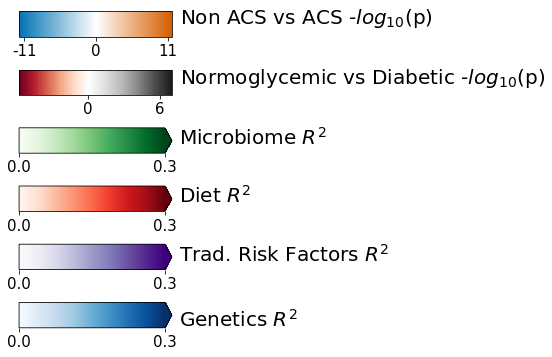

In [51]:
tick_fontsize = 15
label_fontsize = 15

fig, axes = plt.subplots(6, 1, figsize=(8, 5))

ax = axes[0]
norm1 = MidpointNormalize(vmin=df['Healthy-ACS'].min(), 
                          vmax=df['Healthy-ACS'].max(), 
                          midpoint=0)
cmap1 = _get_scale_colors([cm_healthy, cm_acs], df['Healthy-ACS'], return_cmap=True, boundries=[-11, 11])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap1,
                                norm=norm1, ticks=[-11, 0, 11], 
                                orientation='horizontal')
# cb1.set_label('Healthy-ACS ($log_{10}$ pvalue)', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)

cb1.ax.set_xticklabels([-11, 0, 11]) # [-20, 0, 20]
ax.text(df['Healthy-ACS'].max() * 1.1, 0.1, 'Non ACS vs ACS -$log_{10}$(p)', fontsize=label_fontsize+5)

ax = axes[1]
norm1 = MidpointNormalize(vmin=df['DM-ACS'].min(), 
                          vmax=df['DM-ACS'].max(), 
                          midpoint=0)
# cmap1 = _get_scale_colors([plt.cm.RdGy], df['Diabetes'], return_cmap=True, boundries=[-10, 10])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.RdGy,
                                norm=norm1, ticks=[-6, 0, 6], 
                                orientation='horizontal')
# cb1.set_label('Healthy-ACS ($log_{10}$ pvalue)', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
# cb1.ax.set_xticklabels([-6, 0, 5]) 
cb1.ax.set_xticks([-6, 0, 6]) 
ax.text(df['DM-ACS'].max() * 1.1, 0.1, 'Normoglycemic vs Diabetic -$log_{10}$(p)', fontsize=label_fontsize+5)

ax = axes[2]
norm1 = mpl.colors.Normalize(vmin=0, 
                                                 vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Greens,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Microbiome $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.1, 0.1, 'Microbiome $R^2$', fontsize=label_fontsize+5)

ax = axes[3]
norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Reds,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Diet $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.1, 0.1, 'Diet $R^2$', fontsize=label_fontsize+5)

ax = axes[4]
norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Purples,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Genetics $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.1, 0.1, 'Trad. Risk Factors $R^2$', fontsize=label_fontsize+5)

ax = axes[5]
norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Blues,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Clinical data $R^2$', fontsize=label_fontsize, labelpad=1)
cb1.ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set
cb1.ax.yaxis.label.set_size(label_fontsize)
# cb1.ax.xaxis.label.set_position((1, 1))
ax.text(0.3 * 1.1, 0.1, 'Genetics $R^2$', fontsize=label_fontsize+5, va='center')

fig.tight_layout()
plt.savefig(os.path.join(metabolon_dir, 'colorbars_v3.png'), dpi=300)
# plt.savefig(os.path.join(metabolon_dir, 'legend.png'), dpi=800)

# drug deconfounding results

In [52]:
ddp_dir = os.path.join('drug_deconfounding_pipeline')
os.listdir(ddp_dir)

['output_metabolome_20201026.r.filtered',
 'microbiome_significant.csv',
 '.ipynb_checkpoints',
 'metabolon_significant.csv',
 'output_microbiome_20201026.r.filtered']

In [53]:
metabolon_res = pd.read_csv(os.path.join(ddp_dir, 'output_metabolome_20201026.r.filtered'), sep='\t', header=None)
metabolon_res[1] = [s.replace('X', '').replace('...', 'X - ') for s in metabolon_res[1]]
metabolon_res.set_index(1, inplace=True)
metabolon_res[5].value_counts()

SD                                                                 363
gender                                                              53
LD                                                                  45
Age                                                                 39
NC                                                                  21
                                                                  ... 
Age, DM, Dyslipidemia, Statin.intake                                 1
Aspirine.intake, ACE.intake                                          1
Hypertension, Statin.intake, Calcium.antagonist.intake               1
Age, Hypertension, Beta.blocker.intake, Renin.antagonist.intake      1
Age, DM, Statin.intake, Beta.blocker.intake, Metformin.intake        1
Name: 5, Length: 87, dtype: int64

In [54]:
circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]

# FDR 10%
circ_heatmap_df_sorted_fdr01 = circ_heatmap_df_sorted.loc[(fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)))[1] < 0.1)]

In [56]:
df = pd.concat((circ_heatmap_df_sorted_fdr01, metabolon_res), axis=1).dropna(subset=['Healthy-ACS'])
df[~df[5].isin(['NC', 'SD', 'LD'])].dropna(subset=[0, 2, 3, 4, 5])

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2,0,2,3,4,5
100020893,-6.886278,0.172296,0.000000,0.000000,0.300000,0.000000,Metabolome - ACS,0.042025,0.065034,0.141859,"gender, Hypertension, Dyslipidemia, Aspirine.i..."
100001393,-5.125571,0.030000,0.007198,0.095932,0.194419,0.000000,Metabolome - ACS,0.033884,0.053823,0.148009,"Age, gender, bmi"
212,-4.114574,0.380604,0.000000,0.000000,0.155739,0.000000,Metabolome - ACS,0.009412,0.017328,0.181155,"Age, Hypertension, Beta.blocker.intake"
100001256,-3.855148,-0.239675,0.000000,0.000000,0.087573,0.140546,Metabolome - ACS,0.058785,0.087314,0.131853,"Age, gender"
100021123,-3.619135,0.254295,0.000000,0.061218,0.300000,0.000000,Metabolome - ACS,0.000257,0.000617,0.254951,"Age, gender"
...,...,...,...,...,...,...,...,...,...,...,...
X - 11787,3.792319,0.339038,0.001940,0.057568,0.143378,0.000000,Metabolome - ACS,0.000097,0.000250,0.271837,"Age, gender"
X - 13737,-2.598226,-0.137741,0.000000,0.001559,0.123346,0.000000,Metabolome - ACS,0.000353,0.000839,0.249218,"Age, gender"
100020496,-1.997036,0.623229,0.000000,0.000000,0.004823,0.000000,Metabolome - ACS,0.013748,0.023892,-0.169689,smoke_tobacco_now
100000846,-1.406610,1.742541,0.000000,0.000000,0.000000,0.000000,Metabolome - ACS,0.004571,0.009001,0.197832,"Age, DM, Dyslipidemia, Statin.intake"


In [57]:
df[df[5].fillna('').str.contains('intake')][[5]].to_csv(os.path.join(metabolon_dir, 'drug_deconfounding_results.csv'))

In [58]:
df['Confounded by medication'] = df[5].fillna('').str.contains('intake')
df[['Confounded by medication', 5]].sort_values('Confounded by medication', ascending=False).to_csv(os.path.join(metabolon_dir, 'drug_deconfounding_results.csv'))


In [59]:
df[df[5].fillna('').str.contains('intake')].shape

(29, 12)